In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from libpysal.weights import Queen
import esda
from esda.moran import Moran, Moran_Local
import contextily as ctx
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import matplotlib.pyplot as plt
import plotly.express as px
from shapely import wkt
from shapely.wkt import loads
import branca.colormap as cm
import folium

df = pd.read_csv("merged_MAR16.csv")

gdf = gpd.GeoDataFrame(df, geometry=df['wkt'].apply(loads))
gdf.set_crs(epsg=3857, inplace=True)

gdf = gdf.dropna()

invalid_geometries = gdf[~gdf.is_valid]
print(f"Found {len(invalid_geometries)} invalid geometries")
gdf['geometry'] = gdf.geometry.buffer(0)

gdf['snap_rate'] = gdf['snap_rate'].astype(float)
gdf['chd_pct'] = gdf['chd_pct'].astype(float)
gdf['lowaccess_pct'] = gdf['lowaccess_pct'].astype(float)
gdf['lowaccess_li_pct'] = gdf['lowaccess_li_pct'].astype(float)
gdf['snap_rate'] = gdf['snap_rate'].astype(float)
gdf['total_pop'] = gdf['total_pop'].astype(int)

gdf['centroid'] = gdf.geometry.centroid
centroids_geo = gdf['centroid'].to_crs(epsg=4326)


gdf['longitude'] = centroids_geo.x
gdf['latitude'] = centroids_geo.y

gdf = gdf[["geometry", "snap_rate", "chd_pct", "lowaccess_pct", "lowaccess_li_pct", "geoid20", "SPA_NAME"]]

Found 188 invalid geometries


In [3]:
for col in gdf.columns:
    print(col)

geometry
snap_rate
chd_pct
lowaccess_pct
lowaccess_li_pct
geoid20
SPA_NAME


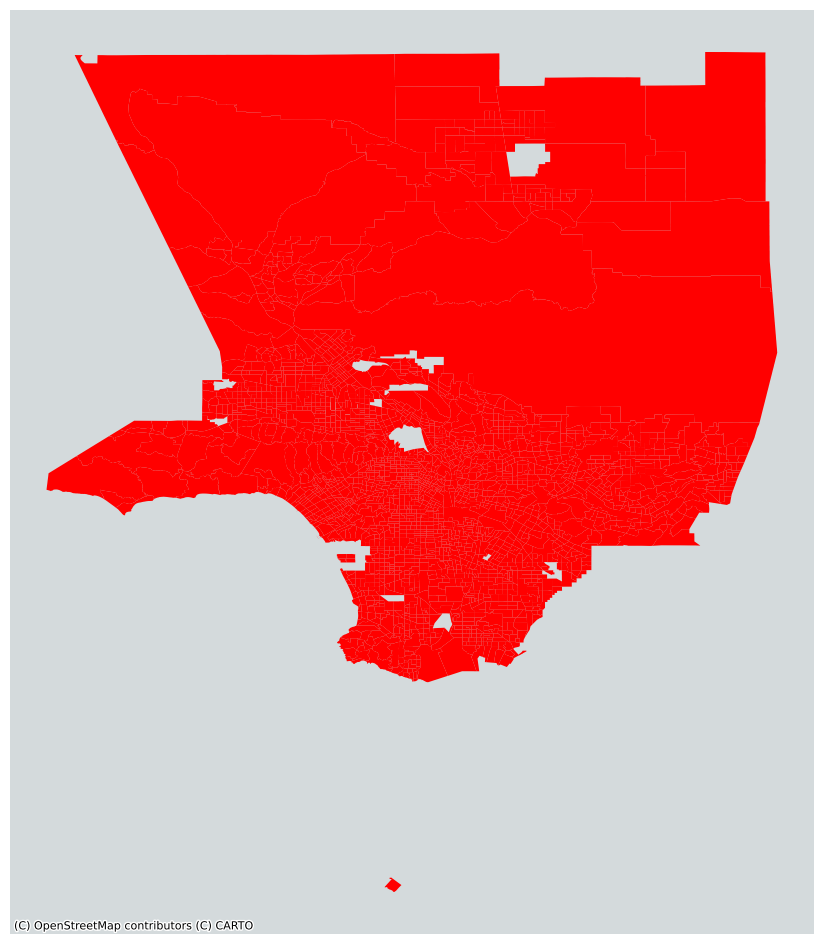

In [4]:
fig,ax = plt.subplots(figsize=(12,12))

gdf.plot(ax=ax,
             color='red',
             markersize=1)

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron, zoom = 10)

In [5]:
wq =  lps.weights.KNN.from_dataframe(gdf,k=8)

wq.transform = 'r'

gdf['chd_pct_lag'] = lps.weights.lag_spatial(wq, gdf['chd_pct'])

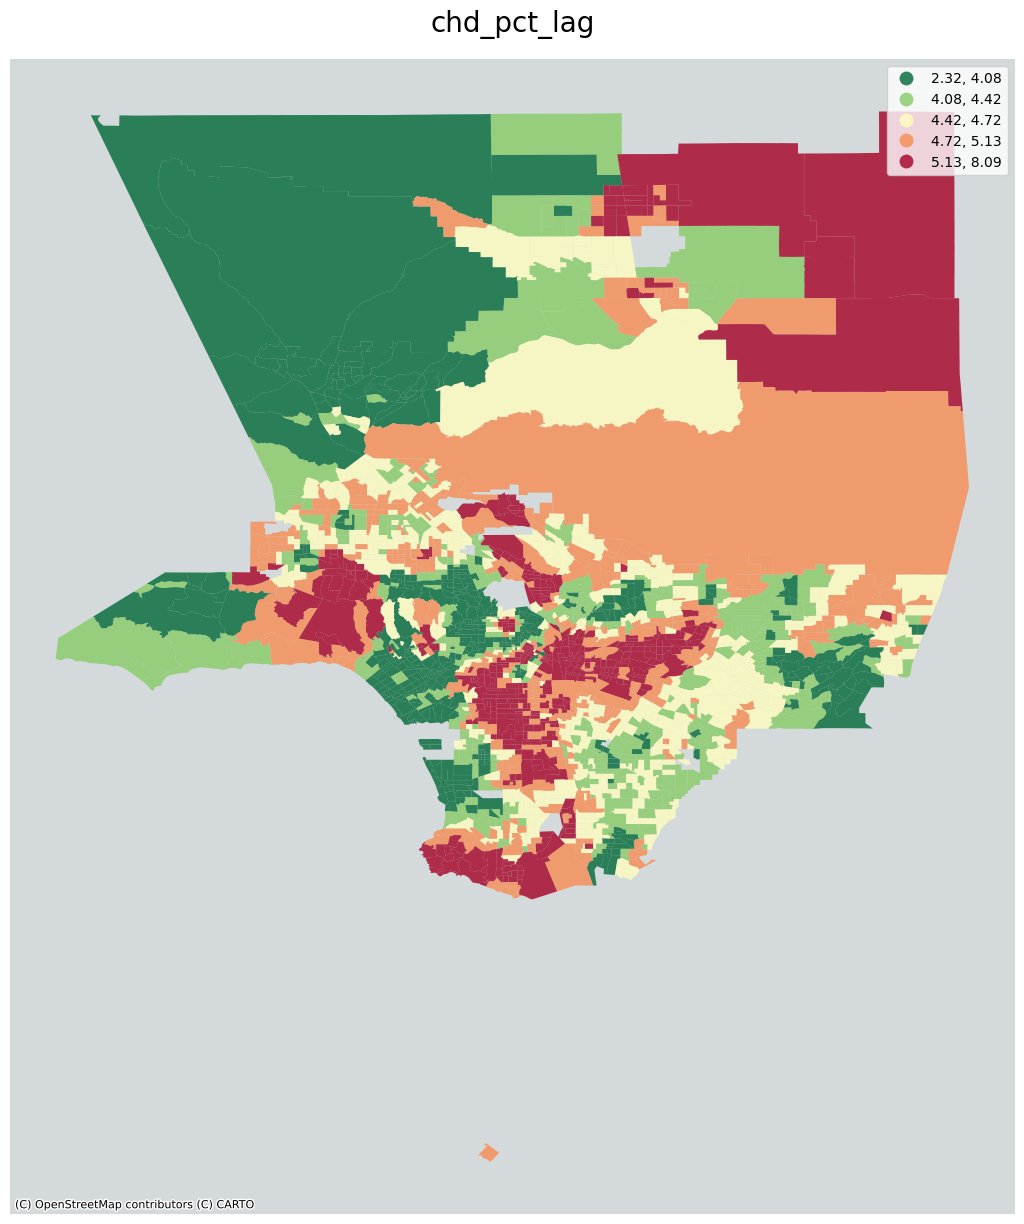

In [6]:
fig, ax = plt.subplots(figsize=(15, 15))

gdf.plot(ax=ax,
         figsize=(15,15),
         column='chd_pct_lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='quantiles')

ax.axis('off')
ax.set_title('chd_pct_lag',fontsize=20,pad=20)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron, zoom = 1)

In [7]:
y = gdf.chd_pct
moran = Moran(y, wq)
moran.I

0.296752748317145

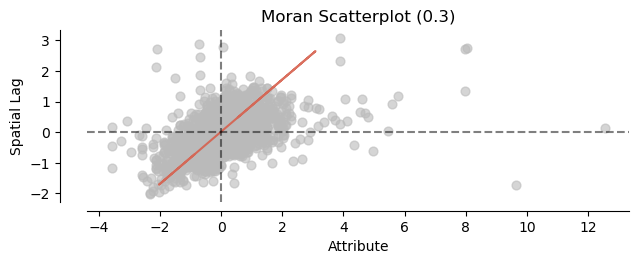

In [8]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.3', ylabel='Density'>)

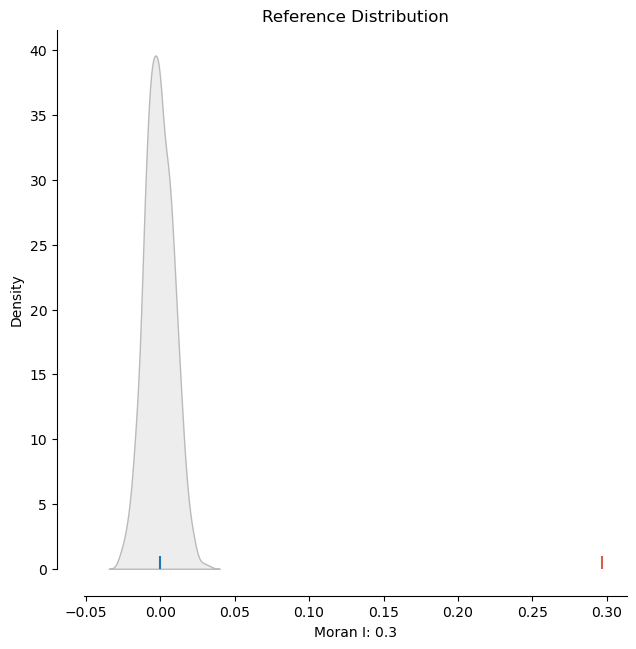

In [9]:
plot_moran_simulation(moran,aspect_equal=False)

In [10]:
moran.p_sim

0.001

In [11]:
lisa = esda.moran.Moran_Local(y, wq)

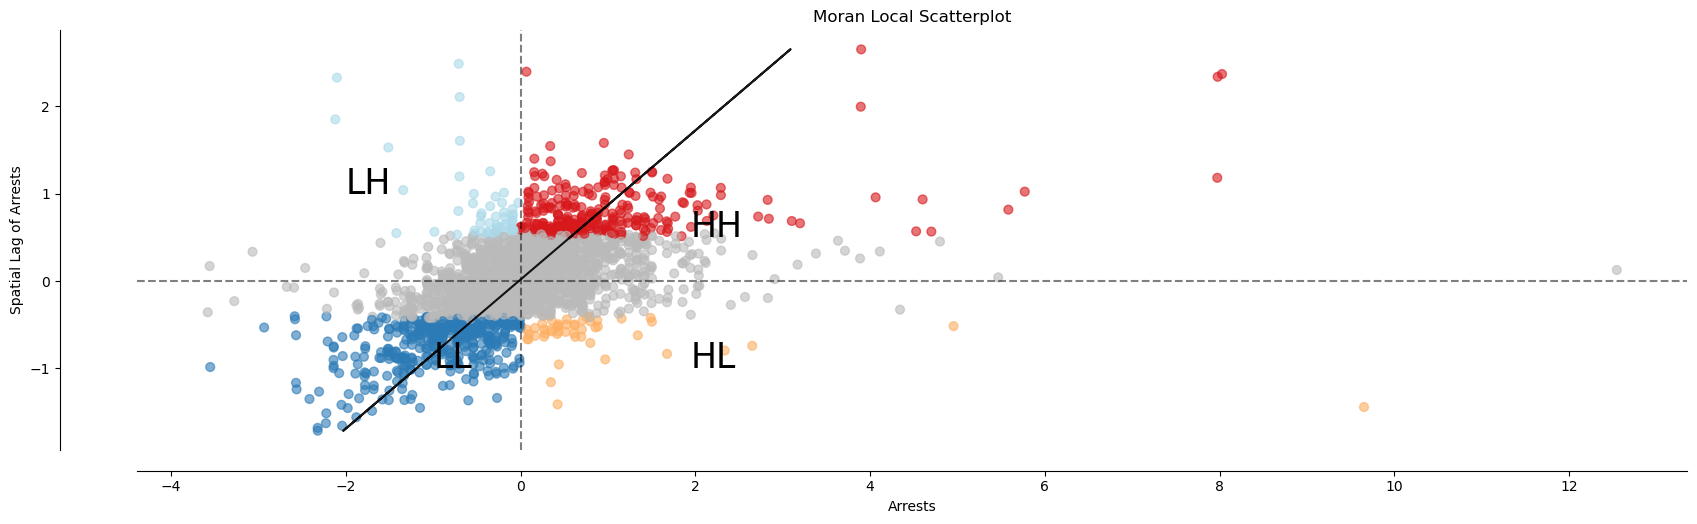

In [12]:
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Arrests")
ax.set_ylabel('Spatial Lag of Arrests')

plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

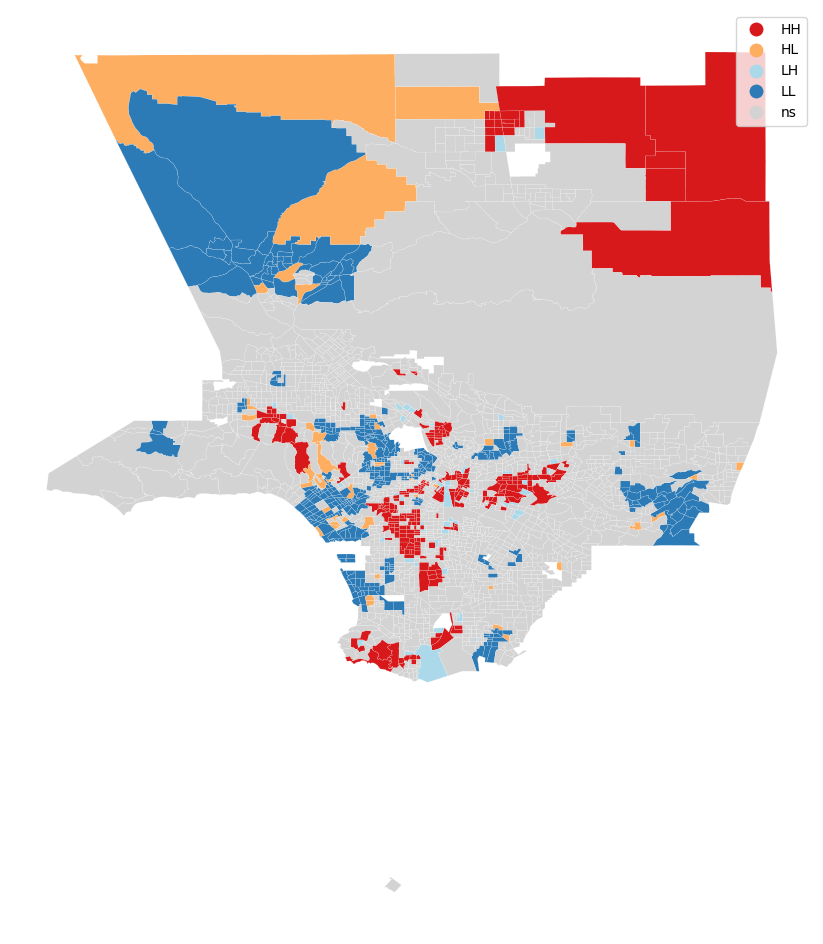

In [13]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf, p=0.05, ax=ax)
plt.show()

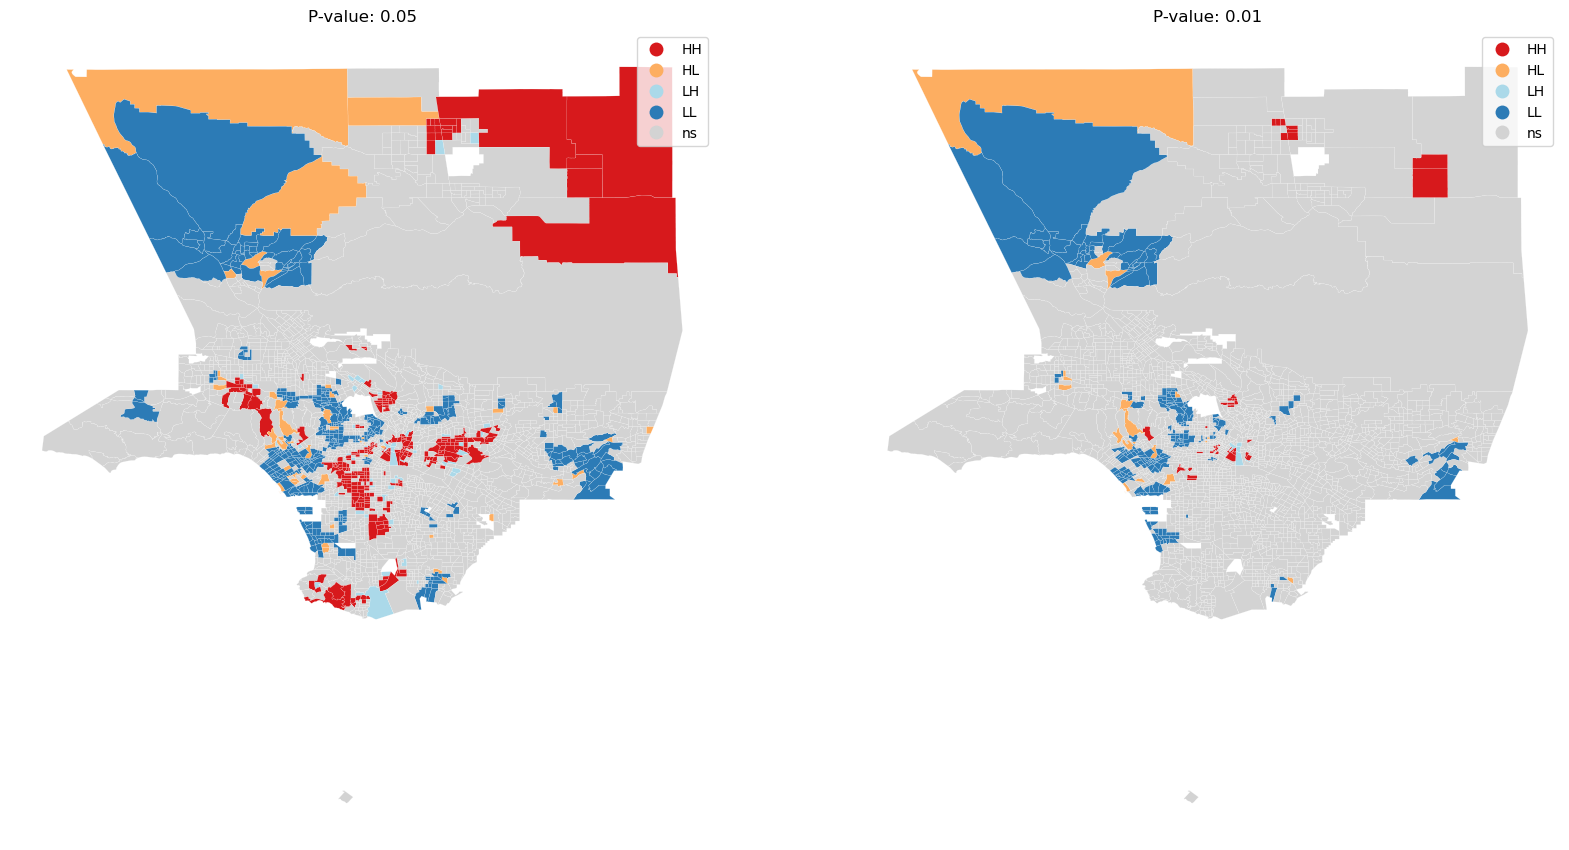

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

lisa_cluster(lisa, gdf, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

lisa_cluster(lisa, gdf, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()